# Parcial 3

### Enunciados Punto 1

Considere las bases de datos del petróleo brent (con nombre __petroleo_brent_historico.csv__) y de la tasa representativa del mercado (__trm_historico.csv__) que se encuentran en la carpeta DATOS del Google Drive.

1. Lea ambas bases de datos.

2. Una las dos bases de datos en una sola BD.

3. Realice un gráfico donde aparezcan ambas series de tiempo.

4. Ajuste un modelo de regresión con los errores descritos por medio de un proceso ARIMA.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Divida la BD en dos conjuntos: entrenamiento y prueba. Usted decide como dividir la serie de tiempo original en estos dos conjuntos.

7. Encuentre un modelo con la función __auto_arima__ para la BD de entrenamiento considerando Brent como variable exógena para explicar la TRM.

8. Realice un diagnóstico del modelo y saque conclusiones.

9. Realice predicciones y compare con los valores de la BD de prueba, utilizando el RMSE y el MAPE.

10. Saque conclusiones.

### Enunciados Punto 2

Vaya al sitio web del DANE haciendo click [AQUÍ](https://www.dane.gov.co/), luego hacer click en  __Estadísticas por tema__, busque en la columna de __Economía__ el item __Construcción__ y hacer click en __Estadísticas de cemento gris (ECG)__. Vaya a __Información adicional__ y hacer click en __Información Histórica__, luego hacer click en __Anexos__  de Septiembre en la tabla del Año 2022. En este punto se descarga automáticamente una base de datos en Excel

1. Lea la BD que se encuentra en el  Anexo 1.

2. Realice un gráfico de puntos XY de la serie Producción en Toneladas versus Despachos Nacionales en Toneladas.

3. Realice un gráfico donde aparezcan ambas series de tiempo a lo largo del tiempo.

4. Mediante la función __auto_arima__ ajuste un modelo SARIMA para ajustar la Producción utilizando como covariable los Despachos Nacionales.

5. Realice un diagnóstico del modelo y saque conclusiones.

6. Realice predicciones para un año.

7. Saque conclusiones.

En la primera celda del trabajo ubique los nombres de los integrantes del grupo de la siguiente forma:

- __Nombre y cédula del integrante 1 del grupo:__



- __Nombre y cédula del integrante 2 del grupo:__


# Punto 2

## 1)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import janitor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from patsy import dmatrix, dmatrices
import pmdarima as pmd
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")


def printfuller(test_res):
    """ null hypothesis is that a unit root is present in a time series sample."""
    print("Prueba de Dickey Fuller")
    print(f"The test statistic: \t {round(test_res[0], 10)}")
    print(f"p-value: \t \t {test_res[1]}")

plt.style.use('fivethirtyeight')
%matplotlib inline

### Limpieza de la Base de Datos:

In [2]:
db = pd.read_excel("Data/Anexos_ECG_sep22.xlsx", sheet_name="Anexo 1 ", 
                   skiprows=8, index_col=None)
db.shape

(171, 11)

In [3]:
db.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
0,2009,NaN,Abr,757117.0,678660.6485,(-),(-),(-),(-),(-),(-)
1,NaN,NaN,May,816612.0,695754.5795,(-),(-),(-),(-),(-),(-)
2,NaN,NaN,Jun,734996.0,635398.9190,(-),(-),(-),(-),(-),(-)
3,NaN,NaN,Jul,767767.0,741963.0250,(-),(-),(-),(-),(-),(-)
4,NaN,NaN,Ago,790129.0,700399.2785,(-),(-),(-),(-),(-),(-)


In [4]:
db.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
166,(-) Sin información,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
167,p Cifra provisional,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,Nota: La producción total de cemento gris cont...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,Nota aclaratoria: Se realiza ajuste en la vari...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170,Actualizado el 28 de octubre 2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
db = db[:-9]
db.tail()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Producción,Despachos Nacionales,Anual,Año corrido,Doce meses,Anual .1,Año corrido.1,Doce meses.1
157,NaN,NaN,May,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
158,NaN,NaN,Jun,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
159,NaN,NaN,Jul,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938
160,NaN,NaN,Ago,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145
161,NaN,NaN,Sep,1.279916e+06,1.188171e+06,4.130198,7.867065,6.706283,2.083653,5.741907,5.078673


In [6]:
db.shape

(162, 11)

In [7]:
db = db.clean_names()
db.columns

Index(['unnamed_0', 'unnamed_1', 'unnamed_2', 'produccion',
       'despachos_nacionales', 'anual_', 'ano_corrido', 'doce_meses',
       'anual_1', 'ano_corrido_1', 'doce_meses_1'],
      dtype='object')

In [8]:
#drop column 1 = unamed_2 
db.drop(['unnamed_1'], axis=1, inplace=True)

In [9]:
db.rename(columns={'unnamed_0':'year', 'unnamed_2':'month'}, inplace=True)

In [10]:
db.dtypes

year                     object
month                    object
produccion              float64
despachos_nacionales    float64
anual_                   object
ano_corrido              object
doce_meses               object
anual_1                  object
ano_corrido_1            object
doce_meses_1             object
dtype: object

In [11]:
year = db.year.iloc[0]

for i in range(1, db.shape[0]):
    if db.year.iloc[i] is np.nan:
        db.year.iloc[i] = year
    else:
        year = db.year.iloc[i]

In [12]:
db.year

0      2009
1      2009
2      2009
3      2009
4      2009
       ... 
157    2022
158    2022
159    2022
160    2022
161    2022
Name: year, Length: 162, dtype: object

In [13]:
replace = {'Ene' : '01', 'Feb' : '02', 'Mar' :'03', 'Abr' : '04', 'May' : '05',
        'Jun' : '06', 'Jul' : '07', 'Ago' : '08', 'Sep' : '09', 'Oct' : '10',
        'Nov' : '11', 'Dic' : '12'}

for i in range(db.shape[0]):
    db.month.iloc[i] = replace[db.month.iloc[i]]

In [14]:
db.month

0      04
1      05
2      06
3      07
4      08
       ..
157    05
158    06
159    07
160    08
161    09
Name: month, Length: 162, dtype: object

In [15]:
db['date'] = db.month + "/" + db.year.astype(str)
db

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1,date
0,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-),04/2009
1,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-),05/2009
2,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-),06/2009
3,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-),07/2009
4,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-),08/2009
...,...,...,...,...,...,...,...,...,...,...,...
157,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026,05/2022
158,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781,06/2022
159,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938,07/2022
160,2022,08,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145,08/2022


In [16]:

db.date = pd.to_datetime(db.date, format="%m/%Y")

## 2) Realice un gráfico de puntos XY de la serie Producción en Toneladas versus Despachos Nacionales en Toneladas.

<Figure size 720x720 with 0 Axes>

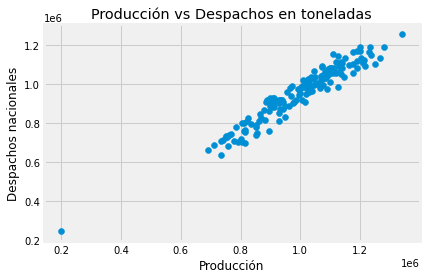

In [17]:
plt.figure(figsize=(10,10))

fig, ax = plt.subplots()
ax.scatter(db.produccion, db.despachos_nacionales)
ax.set_xlabel('Producción')
ax.set_ylabel('Despachos nacionales')
ax.set_title('Producción vs Despachos en toneladas')

plt.show()

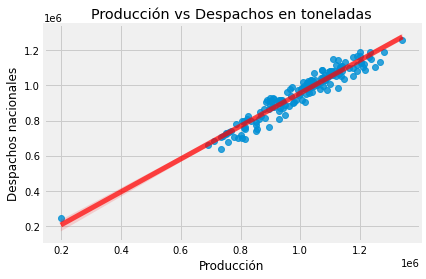

In [18]:
sns.regplot(x=db.produccion, y=db.despachos_nacionales, line_kws={"color":"r", "alpha":0.7,"lw":5})
plt.title('Producción vs Despachos en toneladas')
plt.xlabel('Producción')
plt.ylabel('Despachos nacionales')
plt.show()

Se puede observar una fuente relación lineal entre la produccion y los depachos nacionales.

## 3) Realice un gráfico donde aparezcan ambas series de tiempo a lo largo del tiempo.

In [19]:
serie = db.copy()
serie = db.copy()
serie.set_index("date", inplace=True)
serie

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2009-04-01,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-)
2009-05-01,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-)
2009-06-01,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-)
2009-07-01,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-)
2009-08-01,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-)
...,...,...,...,...,...,...,...,...,...,...
2022-05-01,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
2022-06-01,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
2022-07-01,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938


<AxesSubplot:title={'center':'Serie Producción'}, xlabel='date'>

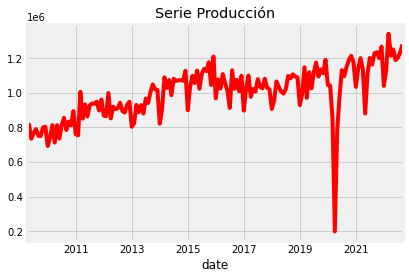

In [20]:
serie.produccion.plot(title="Serie Producción", color="red")

<AxesSubplot:title={'center':'Serie Despachos Nacionales'}, xlabel='date'>

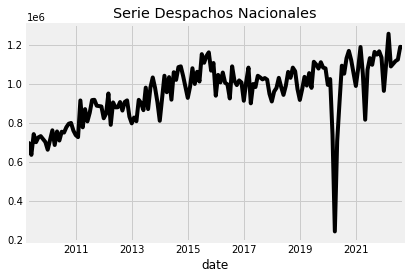

In [21]:
serie.despachos_nacionales.plot(title="Serie Despachos Nacionales", color="black")

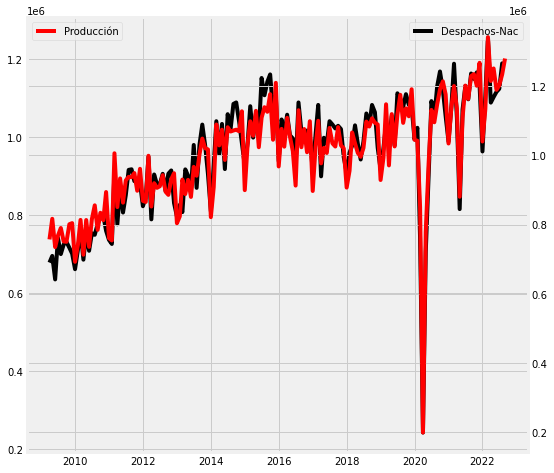

In [22]:
prod = serie.produccion.values
despa = serie.despachos_nacionales.values
date = db.date.values

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
#ax2.set_ylim(0, 150)

ax1.plot(date, despa, color="black", label="Despachos-Nac")
ax2.plot(date, prod, color="red", label="Producción")
ax1.legend(loc="upper right")
#ax2.legend(loc="upper left")
plt.legend()
plt.show()

## 4) Mediante la función auto_arima ajuste un modelo SARIMA para ajustar la Producción utilizando como covariable los Despachos Nacionales.

In [23]:
matriz = dmatrix(serie.despachos_nacionales)
matriz

DesignMatrix with shape (162, 1)
  despachos_nacionales
           678660.6485
           695754.5795
           635398.9190
           741963.0250
           700399.2785
           725187.0710
           731458.2880
           716674.8705
           701444.9590
           661697.3840
           711607.6750
           761517.1535
           686064.2700
           755619.3885
           708921.5525
           754067.7425
           749920.7980
           777478.7460
           795135.3736
           799131.1960
           760219.9770
           736901.4900
           726418.9520
           914686.7650
           776826.3345
           870177.8645
           807107.1370
           851728.5790
           916550.8915
           918049.3045
  [132 rows omitted]
  Terms:
    'despachos_nacionales' (column 0)
  (to view full data, use np.asarray(this_obj))

In [24]:
model = pmd.auto_arima(serie.produccion, X=matriz, stepwise=False,
                      information_criterion="bic", seasonal=True,test="adf",
                       max_p=3, max_q=3, m=12)

In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1912.182
Date:                             Tue, 08 Nov 2022   AIC                           3836.365
Time:                                     19:42:22   BIC                           3854.853
Sample:                                 04-01-2009   HQIC                          3843.872
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    535.0844    411.947      1.299      0.194    -272.317    1342.486
x1             0.9966      0.021     47.742      0.000       0.956       1.037
ma.L1         -1.1654      0.105    -11.119      0.000      -1.371      -0.960
ma.L2          0.2639      0.105      2.509      0.012       0.058       0.470
ar.S.L12       0.4245      0.099      4.301      0.000       0.231       0.618
sigma2      1.502e+09    9.8e-05   1.53e+13      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.06
Prob(Q):                              1.00   Prob(JB):                         0.36
Heteroskedasticity (H):               0.83   Skew:                             0.17
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+29. Standard errors may be unstable.
"""

In [26]:
model = SARIMAX(serie.produccion, exog=matriz, order=(0,1,2), seasonal_order=(1, 0, 0, 12)).fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23011D+01    |proj g|=  9.80884D-01

At iterate    5    f=  1.18023D+01    |proj g|=  8.70677D-02

At iterate   10    f=  1.17948D+01    |proj g|=  7.84063D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   8.783D-06   1.179D+01
  F =   11.794769578615000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          produccion   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1910.753
Date:                             Tue, 08 Nov 2022   AIC                           3831.505
Time:                                     19:42:22   BIC                           3846.912
Sample:                                 04-01-2009   HQIC                          3837.761
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0056      0.023     44.155      0.000       0.961       1.050
ma.L1         -1.1774      0.106    -11.106      0.000      -1.385      -0.970
ma.L2          0.2492      0.111      2.253      0.024       0.032       0.466
ar.S.L12       0.4424      0.095      4.637      0.000       0.255       0.629
sigma2      1.502e+09   5.57e-12    2.7e+20      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.95   Prob(JB):                         0.36
Heteroskedasticity (H):               0.92   Skew:                             0.15
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+37. Standard errors may be unstable.
"""

## 5) Realice un diagnóstico del modelo y saque conclusiones.



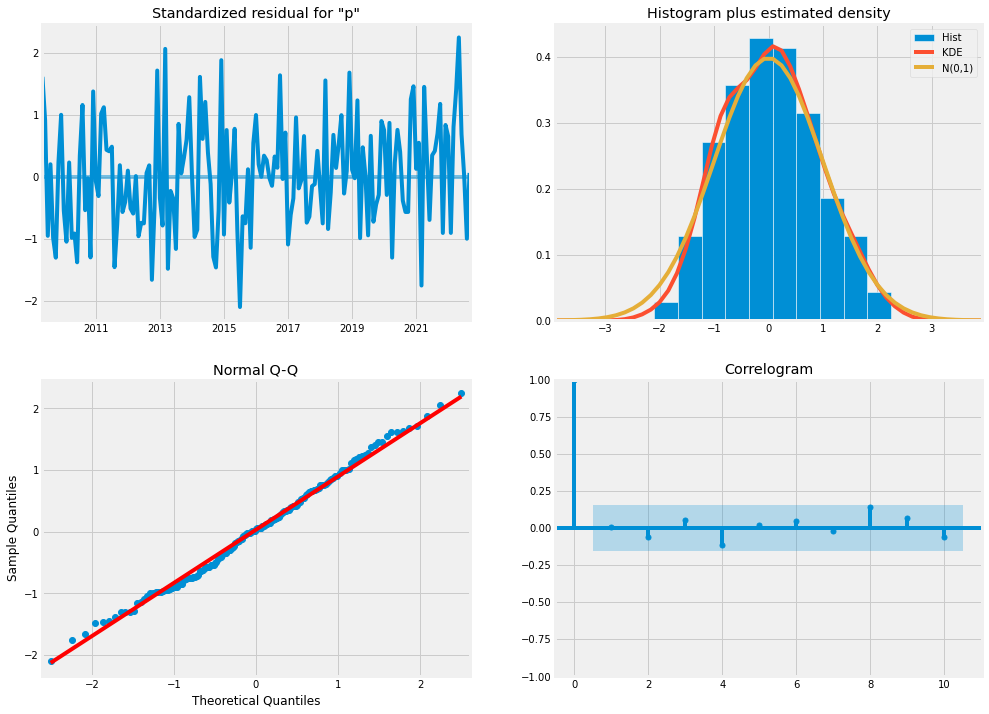

In [27]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          produccion   No. Observations:                  162
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 12)   Log Likelihood               -1910.753
Date:                             Tue, 08 Nov 2022   AIC                           3831.505
Time:                                     19:42:23   BIC                           3846.912
Sample:                                 04-01-2009   HQIC                          3837.761
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0056      0.023     44.155      0.000       0.961       1.050
ma.L1         -1.1774      0.106    -11.106      0.000      -1.385      -0.970
ma.L2          0.2492      0.111      2.253      0.024       0.032       0.466
ar.S.L12       0.4424      0.095      4.637      0.000       0.255       0.629
sigma2      1.502e+09   5.57e-12    2.7e+20      0.000     1.5e+09     1.5e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.03
Prob(Q):                              0.95   Prob(JB):                         0.36
Heteroskedasticity (H):               0.92   Skew:                             0.15
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.12e+37. Standard errors may be unstable.
"""

Con el "mejor" modelo calculado con el auto-rima con los ordenes (0, 1, 2)x(1, 0, 1, 12) se cumple estacionariadad y normalidad para ellos se observa:

- Para la prueba de **Ljung-Box** con un p-valor > 0.05 hay estarcionaridad en la serie.

- Para la prueba de **Jarque-Bera** con un p-valor > 0.05 hay normalidad en la serie. 

## 6) Realice predicciones para un año.



In [29]:
train, test = train_test_split(serie, test_size = 0.05, shuffle = False)

In [30]:
train

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2009-04-01,2009,04,7.571170e+05,6.786606e+05,(-),(-),(-),(-),(-),(-)
2009-05-01,2009,05,8.166120e+05,6.957546e+05,(-),(-),(-),(-),(-),(-)
2009-06-01,2009,06,7.349960e+05,6.353989e+05,(-),(-),(-),(-),(-),(-)
2009-07-01,2009,07,7.677670e+05,7.419630e+05,(-),(-),(-),(-),(-),(-)
2009-08-01,2009,08,7.901290e+05,7.003993e+05,(-),(-),(-),(-),(-),(-)
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,2021,08,1.163339e+06,1.097753e+06,6.183691,24.500757,16.641215,4.341849,24.688655,16.138787
2021-09-01,2021,09,1.229150e+06,1.163919e+06,7.068128,22.080215,16.795706,2.892069,21.563065,15.882596
2021-10-01,2021,10,1.234918e+06,1.150044e+06,3.738473,19.771739,16.631893,-1.631075,18.569294,15.111279


In [31]:
test

,year,month,produccion,despachos_nacionales,anual_,ano_corrido,doce_meses,anual_1,ano_corrido_1,doce_meses_1
date,,,,,,,,,,
2022-01-01,2022,01,1.040161e+06,9.638894e+05,0.562303,0.562303,16.601643,-2.548578,-2.548578,15.92138
2022-02-01,2022,02,1.133914e+06,1.106900e+06,-0.521894,-0.006105,15.598114,2.562758,0.118474,15.604434
2022-03-01,2022,03,1.341585e+06,1.257125e+06,11.767202,4.181705,13.452899,5.72837,2.166224,11.757584
2022-04-01,2022,04,1.214954e+06,1.089207e+06,6.961267,4.881695,6.011502,3.652625,2.528778,4.859489
2022-05-01,2022,05,1.251173e+06,1.103450e+06,42.11479,10.962375,7.985366,35.244803,7.73806,6.221026
2022-06-01,2022,06,1.189315e+06,1.116812e+06,7.297504,10.337343,7.537041,4.195073,7.125149,5.188781
2022-07-01,2022,07,1.202539e+06,1.124720e+06,0.068,8.734832,6.98342,-0.64103,5.925469,4.813938
2022-08-01,2022,08,1.233964e+06,1.189913e+06,6.070958,8.385229,6.969786,8.395314,6.247258,5.157145
2022-09-01,2022,09,1.279916e+06,1.188171e+06,4.130198,7.867065,6.706283,2.083653,5.741907,5.078673


In [32]:
matriz = dmatrix(test.despachos_nacionales)

In [33]:
start = len(train)
end = len(train) + len(test) -1

pred = model.get_prediction(start, end, exog=matriz, dinamyc=False)
pred_ci = pred.conf_int(alpha=0.5)
pred_ci

,lower produccion,upper produccion
2022-01-01,9.887709e+05,1.041059e+06
2022-02-01,1.142756e+06,1.195044e+06
2022-03-01,1.284239e+06,1.336527e+06
2022-04-01,1.134088e+06,1.186376e+06
2022-05-01,1.137966e+06,1.190254e+06
2022-06-01,1.136606e+06,1.188895e+06
2022-07-01,1.176063e+06,1.228351e+06
2022-08-01,1.246425e+06,1.298713e+06
2022-09-01,1.251284e+06,1.303572e+06


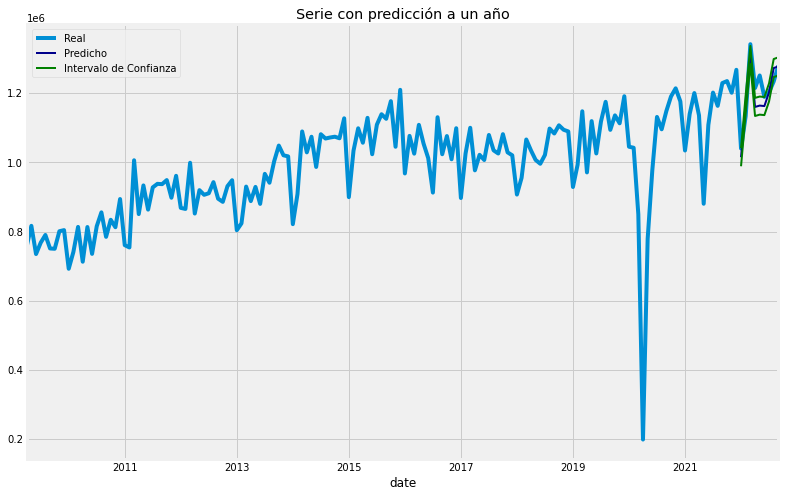

In [34]:
plt.figure(figsize=(12,8))  
serie.produccion.plot()
pred.predicted_mean.plot(color="darkblue", linewidth = 2, title = "Serie con predicción a un año")
pred_ci.iloc[:,0].plot(color="green", linewidth = 2)
pred_ci.iloc[:,1].plot(color="green", linewidth = 2)

plt.legend(["Real", "Predicho", "Intervalo de Confianza"])
plt.show()

## 7) Saque conclusiones.

Las predicciones realizadas para el conjunto de datos de prueba con el modelo teniendo presente como variable exógena los despachos nacionales son relativamente buenas, pero se sugiere modelar la intervención presenta en el año 2020 por causa de la pandemia.